## 분석에 필요한 모듈 임포트

In [48]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import shuffle
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

`from sklearn.preprocessing import Imputer`의 경우 존재하지 않는 모듈이라는 오류가 떠서 제외하였습니다.

## 데이터 로딩

In [49]:
trainset = pd.read_csv('../input/train.csv')
testset = pd.read_csv('../input/test.csv')

#### ✅ 절대 경로와 상대 경로
- 절대 경로 : 어떠한 웹페이지나 파일이 가지고 있는 고유한 경로
- 상대 경로 : '현재 위치한 곳을 기준' 으로 한 경로

따라서, `trainset`과 `testset`의 경로는 절대 경로와 상대 경로 모두로도 사용할 수 있습니다. 위의 예시는 상대 경로를 사용한 것인데요.

`Kaggle/week01/input` 에 `train.csv`와 `test.csv`가 존재하고, 현재 작업 중인 디렉토리는

In [50]:
import os
os.getcwd()

'C:\\Users\\USER\\PycharmProjects\\Kaggle_local\\week01\\Eunhee'

`Kaggle/week01/Eunhee`입니다. 즉, 현재 디렉토리에서 한 단계 상위 디렉토리로 이동한 다음, `input` 으로 이동해야 비로소 `train.csv`와 `test.csv`를 이용할 수 있는 것이죠.
- / : 최상위 디렉토리로 이동
- ./ : 현재 디렉토리를 의미
- ../ : 한 단계 상위 디렉토리로 이동
    - 예) 두 단계 상위 디렉토리로 이동 시 ../../

자세한 설명은 [링크](https://88240.tistory.com/122) 의 글을 참고해 주세요.

## 데이터에 대한 사전 이해
- 몇 가지 **그룹**들이 정의되어 있고, 이러한 그룹에 속해 있는 특징들은 이름에 패턴을 포함(`ind`, `reg`, `car`, `calc`)합니다. **ind**는 individual, **reg**은 registration, **car**은 self-explanatory, **calc**은 calculated field 를 의미합니다.
- 접미사 `bin`은 binary feature 에 대해 사용됩니다.
- 접미사 `cat`은 categorical features 에 대해 사용됩니다.
- `bin`이나 `cat`이 없는 특징들은 실수나 정수입니다.
- 결측치는 `-1`으로 나타냅니다.
- 예측의 관심은 `target` 컬럼입니다. 이것은 해당 보험자에 대한 보험금 청구가 접수되었는지 여부를 나타냅니다.
- `id`는 데이터 인풋, 숫자형입니다.

In [51]:
trainset.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [52]:
print("Train dataset (rows, cols) :", trainset.shape, "\nTest dataset (rows, cols) :", testset.shape)

Train dataset (rows, cols) : (595212, 59) 
Test dataset (rows, cols) : (892816, 58)


training set 에는 59개의 컬럼이 있는데, test set 에는 58개의 컬럼이 있습니다. 이는 `target` 컬럼이 test set 에는 존재하지 않기 때문인데요. 파이썬의 `set` 자료형과 차집합 원리를 이용하여 쉽게 확인할 수 있씁니다.

In [53]:
print("Columns in train and not in test dataset :", set(trainset.columns)-set(testset.columns))

Columns in train and not in test dataset : {'target'}


## 메타데이터
- use : input, ID, target
- type : nominal, interval, ordinal, binary
- preserve : True, False
- dataType : int, float, char
- category : ind, reg, car,calc

In [54]:
data = []
for feature in trainset.columns:
    if feature == 'target':
        use = 'target'
    elif feature == 'id':
        use = 'id'
    else:
        use = 'input'

    if 'bin' in feature or feature == 'target':
        type = 'binary'
    elif 'cat' in feature or feature == 'id':
        type = 'categorical'
    elif trainset[feature].dtype == float or isinstance(trainset[feature].dtype, float):
        type = 'real'
    elif trainset[feature].dtype == int:
        type == 'integer'

    preserve = True
    if feature == 'id':
        preserve = False

    dtype = trainset[feature].dtype

    category = 'none'
    if 'ind' in feature:
        category = 'individual'
    elif 'reg' in feature:
        category = 'registration'
    elif 'car' in feature:
        category = 'car'
    elif 'calc' in feature:
        category = 'calculated'

    feature_dictionary = {
        'varname' : feature,
        'use' : use,
        'type' : type,
        'preserve' : preserve,
        'dtype' : dtype,
        'category' : category
    }
    data.append(feature_dictionary)

metadata = pd.DataFrame(data, columns=['varname', 'use', 'type', 'preserve', 'dtype', 'category'])
metadata.set_index('varname', inplace=True)
metadata

,use,type,preserve,dtype,category
varname,,,,,
id,id,categorical,False,int64,none
target,target,binary,True,int64,none
ps_ind_01,input,binary,True,int64,individual
ps_ind_02_cat,input,categorical,True,int64,individual
ps_ind_03,input,categorical,True,int64,individual
ps_ind_04_cat,input,categorical,True,int64,individual
ps_ind_05_cat,input,categorical,True,int64,individual
ps_ind_06_bin,input,binary,True,int64,individual
ps_ind_07_bin,input,binary,True,int64,individual


모든 범주형 변수들을 가져옵니다.

In [55]:
metadata[(metadata.type == 'categorical') & (metadata.preserve)].index

Index(['ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat', 'ps_ind_05_cat',
       'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat',
       'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat',
       'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_car_11'],
      dtype='object', name='varname')

주어진 카테고리를 기준으로 분류합니다.

In [56]:
pd.DataFrame({'count' : metadata.groupby(['category'])['category'].size()}).reset_index()

,category,count
0,calculated,20
1,car,16
2,individual,18
3,none,2
4,registration,3


그 다음에는 이를 type을 기준으로 분류합니다.

In [57]:
pd.DataFrame({'count' : metadata.groupby(['use', 'type'])['use'].size()}).reset_index()

,use,type,count
0,id,categorical,1
1,input,binary,20
2,input,categorical,16
3,input,real,21
4,target,binary,1


## 데이터 분석과 통계
### 타깃 변수

<Figure size 432x288 with 0 Axes>

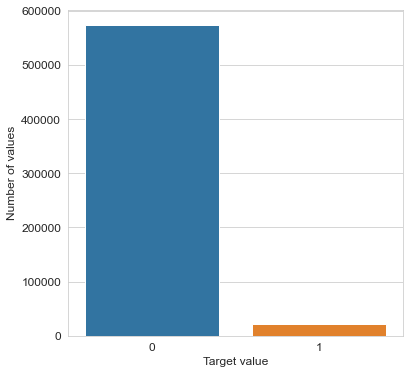

In [58]:
plt.figure()
fig, ax = plt.subplots(figsize=(6,6))
x = trainset['target'].value_counts().index.values
y = trainset["target"].value_counts().values

sns.barplot(ax=ax, x=x, y=y)
plt.ylabel('Number of values', fontsize=12)
plt.xlabel('Target value', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

-`.value_counts()` : 컬럼/Series 의 unique value 들을 count 해주는 함수로, unique value 들과 count 들을 리턴합니다.
- `x` : `target`의 분류, 즉 0 또는 1
- `y` : `target`의 분류별 개수, 예를 들어 0에는 몇 개, 1에는 몇 개
- `plt.tick_params` : 눈금 스타일을 적용하는 함수, 이 설정은 x축&y축 모두에 적용하고, major 눈금으로!

## 실제 feature 들

`metadata.type`이 `real`이고, `metadata.preserve`가 `True`인 변수들을 찾습니다.

In [59]:
metadata[(metadata.type == 'real') & (metadata.preserve)].T

varname,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,...,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
use,input,input,input,input,input,input,input,input,input,input,...,input,input,input,input,input,input,input,input,input,input
type,real,real,real,real,real,real,real,real,real,real,...,real,real,real,real,real,real,real,real,real,real
preserve,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
dtype,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64
category,registration,registration,registration,car,car,car,car,calculated,calculated,calculated,...,calculated,calculated,calculated,calculated,calculated,calculated,calculated,calculated,calculated,calculated


In [60]:
variable = metadata[(metadata.type == 'real') & (metadata.preserve)].index
trainset[variable].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,...,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,...,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849,...,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153,...,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000,...,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000,...,2.000000,8.000000,3.000000,9.000000,2.000000,8.000000,5.000000,1.000000,3.000000,7.000000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000,...,3.000000,9.000000,4.000000,10.000000,3.000000,10.000000,7.000000,2.000000,4.000000,9.000000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000,...,6.000000,10.000000,9.000000,12.000000,7.000000,25.000000,19.000000,10.000000,13.000000,23.000000


이러한 변수들을 `trainset`에서 골라내었습니다.

In [61]:
(pow(trainset['ps_car_12']*10, 2)).head(10)

0    16.00
1    10.00
2    10.00
3    14.00
4     9.99
5    19.89
6    10.00
7    19.98
8    16.00
9    20.00
Name: ps_car_12, dtype: float64

In [62]:
(pow(trainset['ps_car_15'], 2)).head(10)

0    13.0
1     6.0
2    11.0
3     4.0
4     4.0
5     9.0
6    10.0
7    11.0
8     8.0
9    13.0
Name: ps_car_15, dtype: float64

### 결측치가 있는 feature 들
`ps_reg_o3`, `ps_car_12`, `ps_car_14`가 결측치를 가지고 있다고 합니다만 실행해 보니 모든 컬럼에서 결측치를 확인할 수 없었습니다.

In [63]:
trainset.isnull().sum().sum()

0

### Registration feature 들
`ps_reg_01`과 `ps_reg_02`은 분모가 10인 (0.1, 0.2 처럼) 분수 형태의 값들을 가지는 변수입니다.
### Car feature 들
`ps_car_12`는 10을 곱하여 제곱하면 자연수에 근접하며, `ps_car_15`는 제곱하면 자연수가 되는 특징이 있습니다.

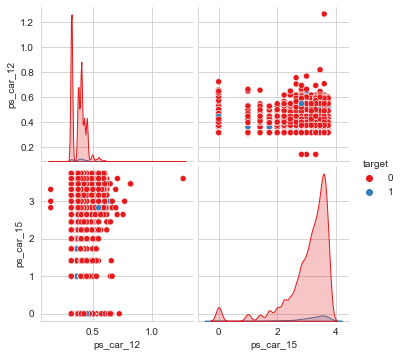

In [64]:
sample = trainset.sample(frac=0.05)
var = ['ps_car_12', 'ps_car_15', 'target']
sample = sample[var]
sns.pairplot(sample, hue='target', palette='Set1', diag_kind='kde')
plt.show()

- `sns.pairplot` : `sample`을 가지고 그림을 그리고, `target`을 색깔 기준으로 삼습니다, 색상은 `Set1`에 사전 지정된 색깔을 사용하며 대각선에는 커널 밀도 추정 곡선을 볼 수 있게(`kde`) 합니다.
> 커널 밀도 추정 곡선 : non-parametric 밀도추정 방법 중 하나로서 커널함수(kernel function)를 이용하여 히스토그램 방법의 문제점을 개선한 방법

`ps_calc_01`, `ps_calc_02`, `ps_calc_03`은 비슷한 분포를 가지고 있다고 합니다. 시각화해서 살펴보도록 하겠습니다.

<Figure size 432x288 with 0 Axes>

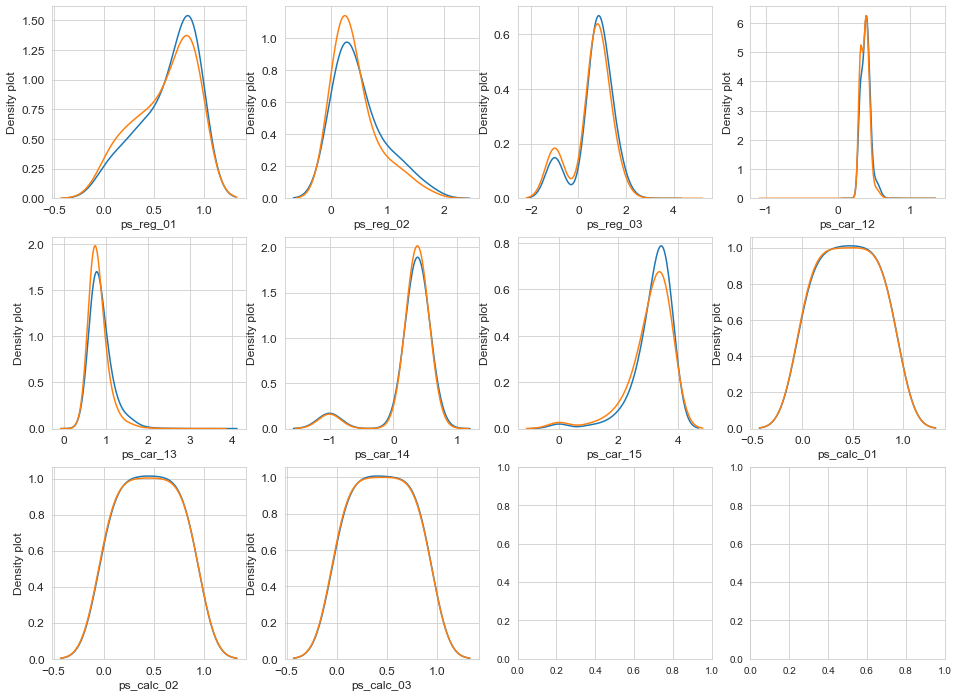

In [65]:
var = ['ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03']

i = 0
t1 = trainset.loc[trainset['target'] != 0]
t0 = trainset.loc[trainset['target'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(3, 4,figsize=(16,12))

for feature in var:
    i += 1
    plt.subplot(3, 4,i)
    sns.kdeplot(t1[feature], bw=0.5,label="target = 1")
    sns.kdeplot(t0[feature], bw=0.5,label="target = 0")
    plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

원본 코드에서 `var` 정의가 잘못되어 오류가 발생합니다. 그래서 직접 `var`을 설정해 주었습니다. 무슨 기준으로 `var`을 정의했는지는 잘 모르겠어요.

마찬가지로 수정한 var 을 가지고 feature 들 간의 상관관계를 시각화 해 보겠습니다.

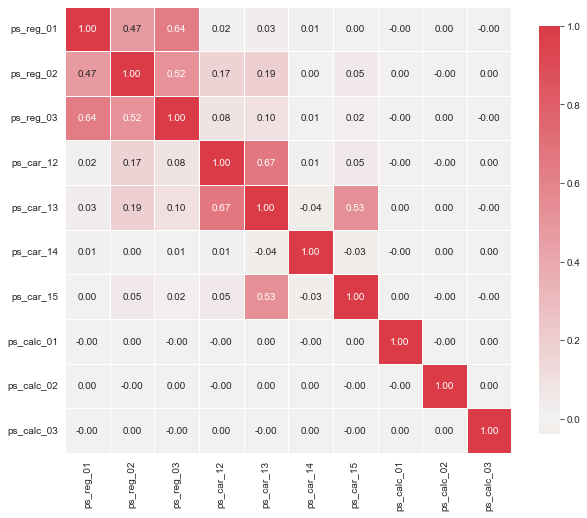

In [66]:
def corr_heatmap(var):
    correlations = trainset[var].corr()
    cmap = sns.diverging_palette(50, 10, as_cmap=True)
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .75})
    plt.show()

corr_heatmap(var)

- `ps_reg_01`과 `ps_reg_02`가 가지는 상관관계는 0.47
- `ps_reg_01`과 `ps_reg_03`가 가지는 상관관계는 0.64
- `ps_reg_02`와 `ps_reg_03`이 가지는 상관관계는 0.52
- `ps_car_12`와 `ps_car_13`이 가지는 상관관계는 0.67
- `ps_car_13`과 `ps_car_15`가 가지는 상관관계는 0.53

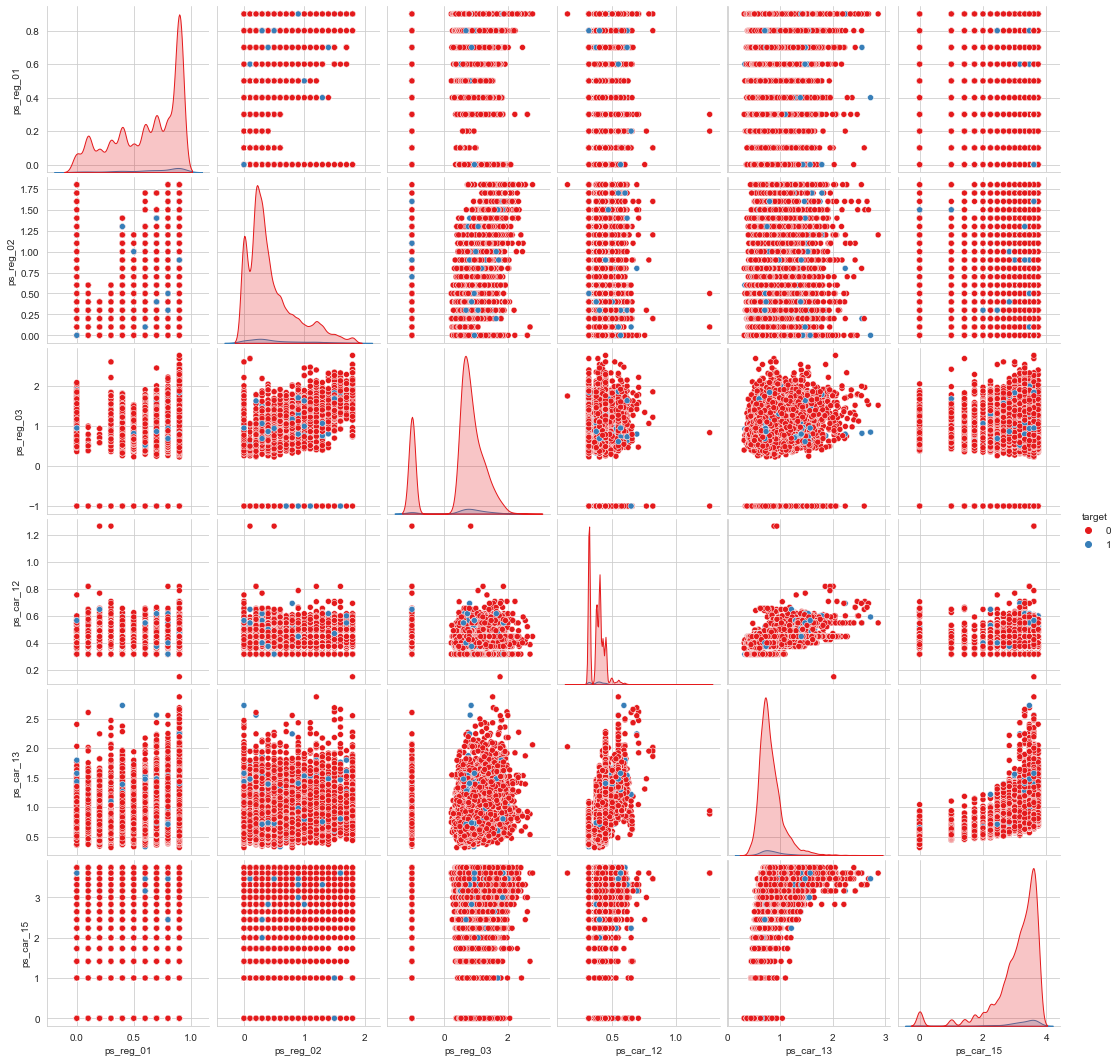

In [67]:
sample = trainset.sample(frac=0.05)
var = ['ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_12', 'ps_car_13', 'ps_car_15', 'target']
sample = sample[var]
sns.pairplot(sample,  hue='target', palette = 'Set1', diag_kind='kde')
plt.show()

## Binary features

In [68]:
v = metadata[(metadata.type == 'binary') & (metadata.preserve)].index
trainset[v].describe()

,target,ps_ind_01,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,...,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,...,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,1.900378,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,...,7.299922,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,1.983789,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,...,3.546042,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,7.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,3.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,10.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,13.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


훈련 데이터셋에서 `0`과 `1`의 비율을 각각 파란색과 빨간색으로 그려보도록 하겠습니다.

<Figure size 432x288 with 0 Axes>

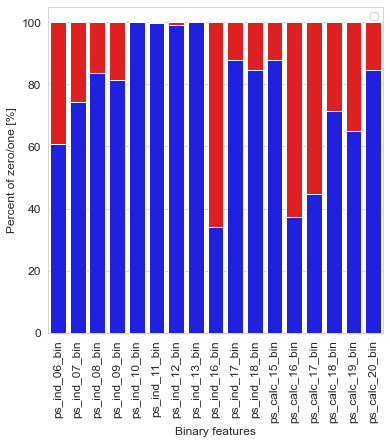

In [69]:
bin_col = [col for col in trainset.columns if '_bin' in col]
zero_list = []
one_list = []
for col in bin_col:
    zero_list.append((trainset[col] == 0).sum() / trainset.shape[0] * 100)
    one_list.append((trainset[col] == 1).sum() / trainset.shape[0] * 100)

plt.figure()
fig, ax = plt.subplots(figsize=(6, 6))

p1 = sns.barplot(ax=ax, x=bin_col, y=zero_list, color="blue")
p2 = sns.barplot(ax=ax, x=bin_col, y=one_list, bottom=zero_list, color="red")

plt.ylabel('Percent of zero/one [%]', fontsize=12)
plt.xlabel('Binary features', fontsize=12)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend((p1, p2), ('Zero', 'One'))
plt.show()

`ps_ind_10_bin`, `ps_ind_11_bin`, `ps_ind_12_bin`, `ps_ind_13_bin` 은 `1` 값이 0.5% 이하로 적고, `ps_ind_16_bin`과 `ps_calc_16_bin`은 60% 이상으로 많이 차지합니다.

<Figure size 432x288 with 0 Axes>

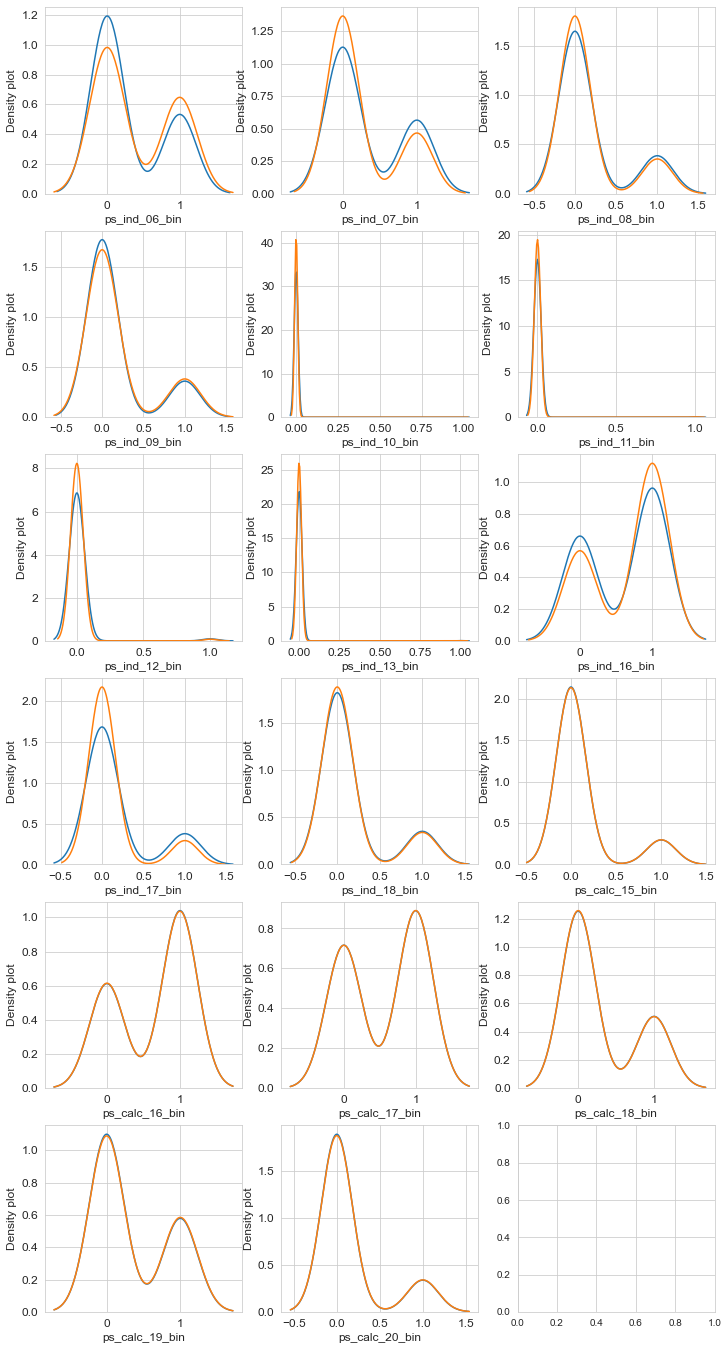

In [70]:
var = metadata[(metadata.type == 'binary') & (metadata.preserve)].index
var = [col for col in trainset.columns if '_bin' in col]
i = 0
t1 = trainset.loc[trainset['target'] != 0]
t0 = trainset.loc[trainset['target'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(6, 3, figsize=(12, 24))

for feature in var:
    i += 1
    plt.subplot(6, 3, i)
    sns.kdeplot(t1[feature], bw=0.5, label="target = 1")
    sns.kdeplot(t0[feature], bw=0.5, label="target = 0")
    plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

`ps_ind_06_bin`, `ps_ind_07_bin`, `ps_ind_16_bin`, `ps_ind_17_bin`은 `0`과 `1`의 분포 차이가 불균형하게 나타나는 반면, `ps_ind_08_bin`은 그 불균형의 차이가 작은 편입니다.

## 범주형 feature 들
우선, 범주 값별 `target=1`의 비율을 계산하고 그 비율을 막대 그래프로 나타내 봅시다.

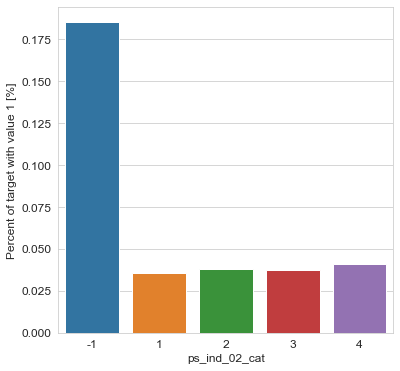

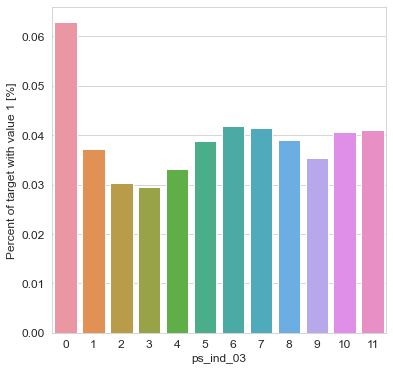

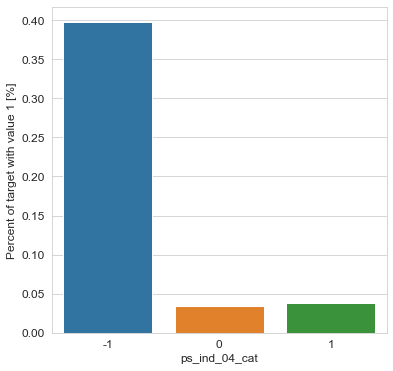

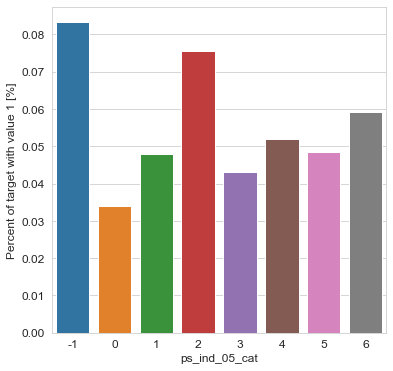

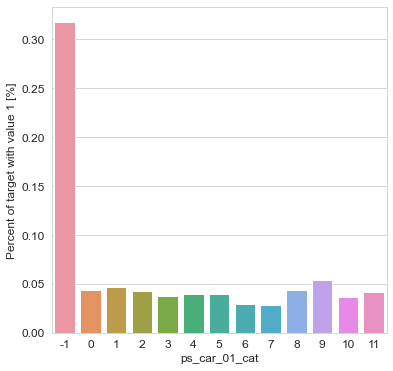

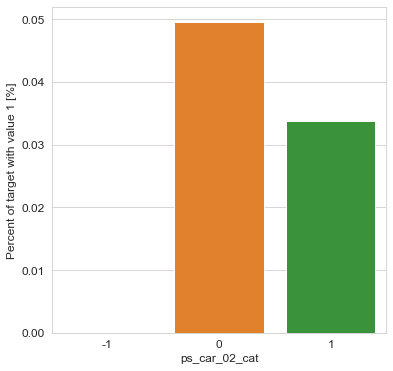

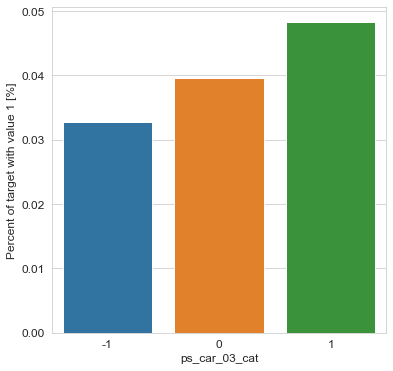

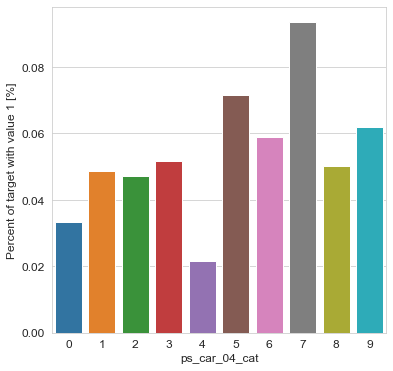

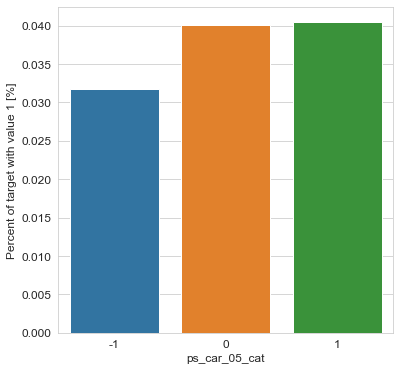

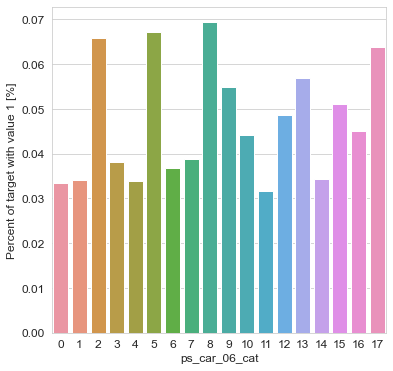

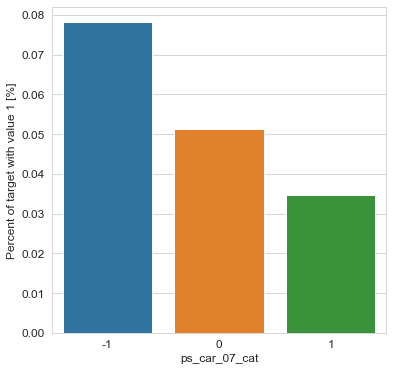

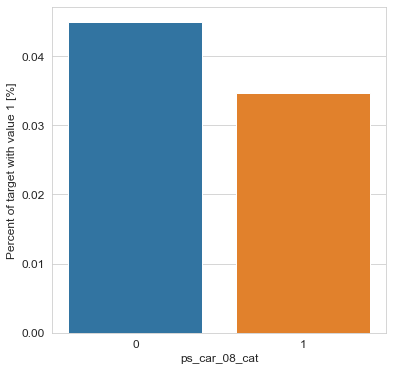

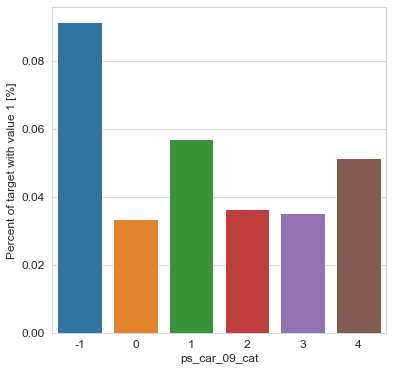

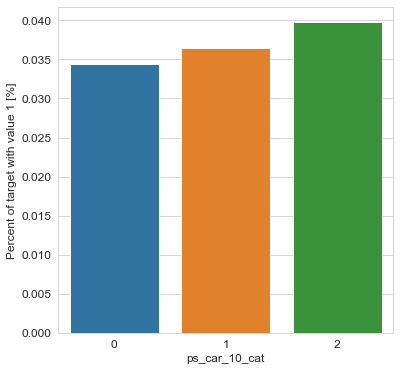

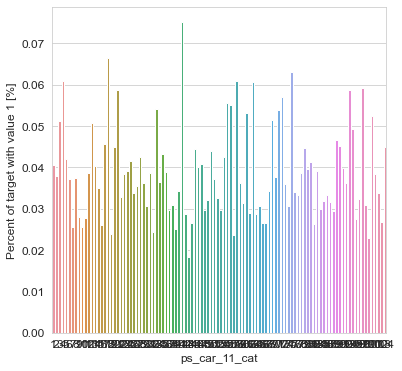

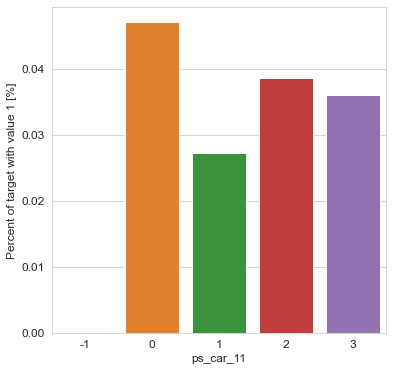

In [71]:
var = metadata[(metadata.type == 'categorical') & (metadata.preserve)].index

for feature in var:
    fig, ax = plt.subplots(figsize=(6, 6))
    cat_perc = trainset[[feature, 'target']].groupby([feature], as_index=False).mean()
    cat_perc.sort_values(by='target', ascending=False, inplace=False)
    sns.barplot(ax=ax, x=feature, y='target', data=cat_perc, order=cat_perc[feature])
    plt.ylabel('Percent of target with value 1 [%]', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show()

`trainset` 데이터에 대해 매 `feature`와 `target` 컬럼을 가져오고, 이를 `feature` 그룹별 평균 집계를 수행합니다.

<Figure size 432x288 with 0 Axes>

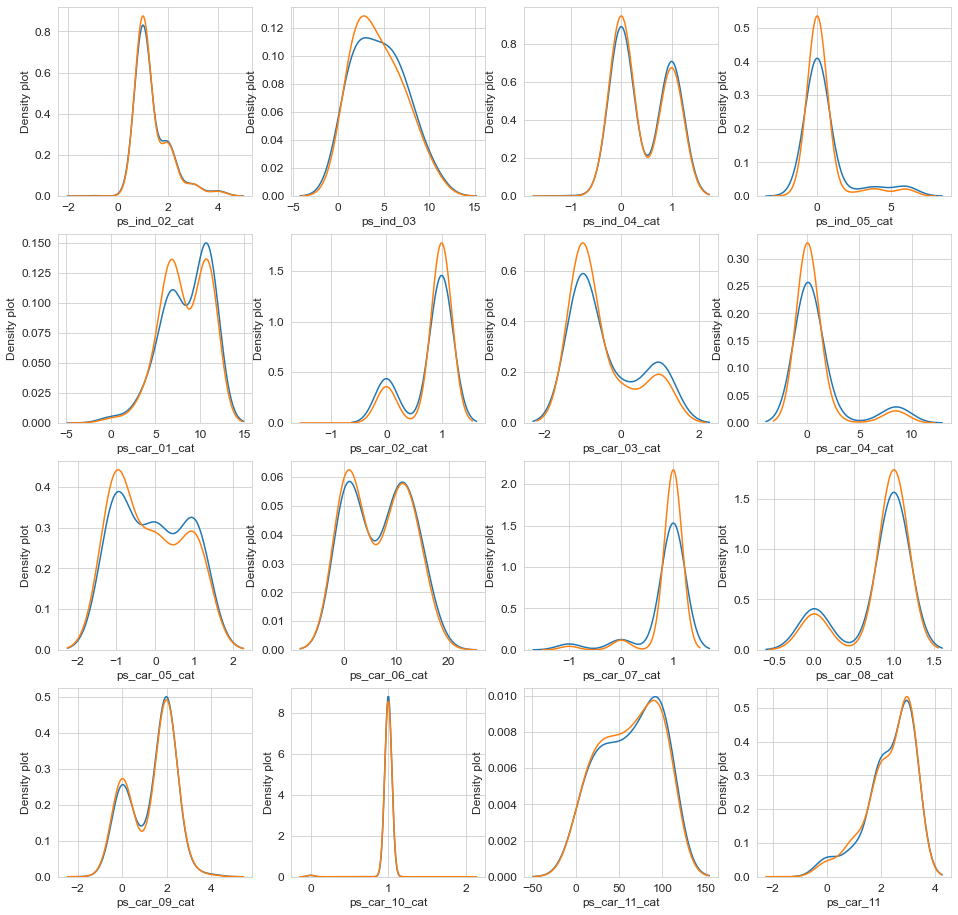

In [72]:
var = metadata[(metadata.type == 'categorical') & metadata.preserve].index
i = 0
t1 = trainset.loc[trainset['target'] != 0]
t0 = trainset.loc[trainset['target'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(4, 4, figsize=(16, 16))

for feature in var:
    i += 1
    plt.subplot(4, 4, i)
    sns.kdeplot(t1[feature], bw=0.5, label="target = 1")
    sns.kdeplot(t0[feature], bw=0.5, label="target = 0")
    plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

시각화 결과 `ps_car_03_cat`, `ps_car_05_cat`이 `target=0`와 `target=1`의 차이가 가장 두드러진다고 되어 있는데요, 시각화 결과는 조금 다르게 나타났습니다.

## 훈련 데이터와 테스트 데이터의 불균형
훈련 데이터셋과 테스트 데이터셋의 feature 들의 분포를 비교해 봅시다. 먼저 `reg`(`registration`)에 대해 살펴보겠습니다.

<Figure size 432x288 with 0 Axes>

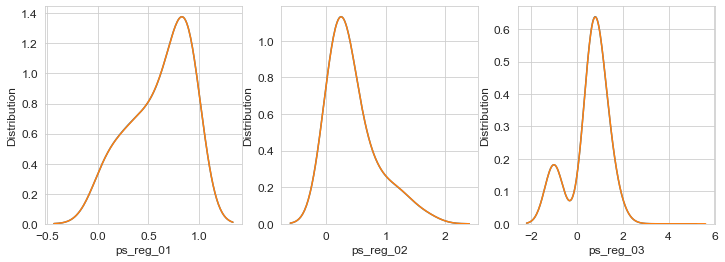

In [73]:
var = metadata[(metadata.category == 'registration') & (metadata.preserve)].index
sns.set_style('whitegrid')

plt.figure()
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
i = 0
for feature in var:
    i += 1
    plt.subplot(1, 3, i)
    sns.kdeplot(trainset[feature], bw=0.5, label="train")
    sns.kdeplot(testset[feature], bw=0.5, label="test")
    plt.ylabel('Distribution', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

모든 `reg` feature 에 대하여 훈련 데이터셋과 테스트 데이터셋이 균형있게 분포되어 있음을 확인할 수 있었습니다.

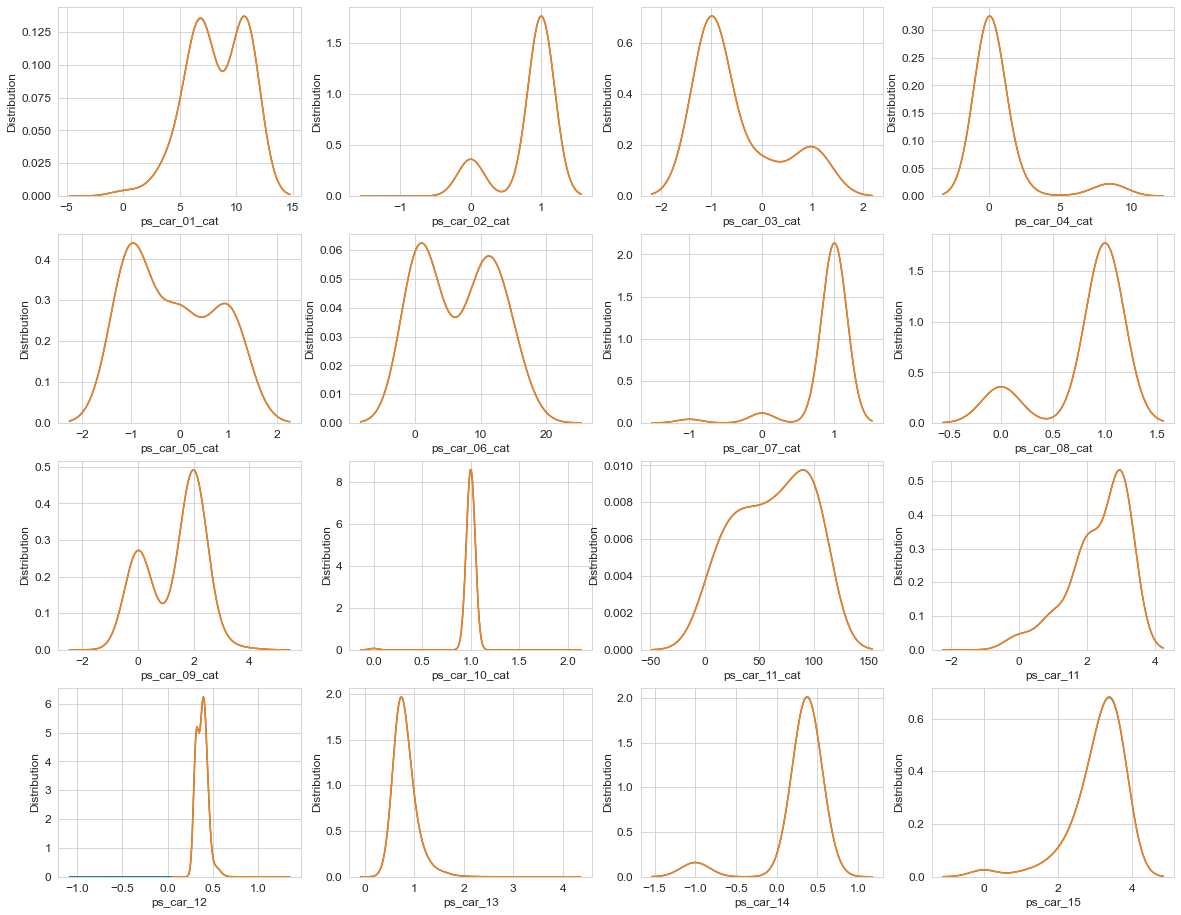

In [74]:
var = metadata[(metadata.category == 'car') & (metadata.preserve)].index
sns.set_style('whitegrid')

fig, ax = plt.subplots(4, 4, figsize=(20, 16))
i = 0
for feature in var:
    i += 1
    plt.subplot(4, 4, i)
    sns.kdeplot(trainset[feature], bw=0.5, label="train")
    sns.kdeplot(testset[feature], bw=0.5, label="test")
    plt.ylabel('Distribution', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

일부 변수들의 개형이 원본 코드와는 다르지만, 이 경우에도 훈련 데이터셋과 테스트 데이터셋이 균형있게 분포되어 있음을 확인할 수 있습니다. `ind`(`individual`), `calc`(`calculation`) 변수에 대해서도 같은 방식으로 그림을 그려봅니다.

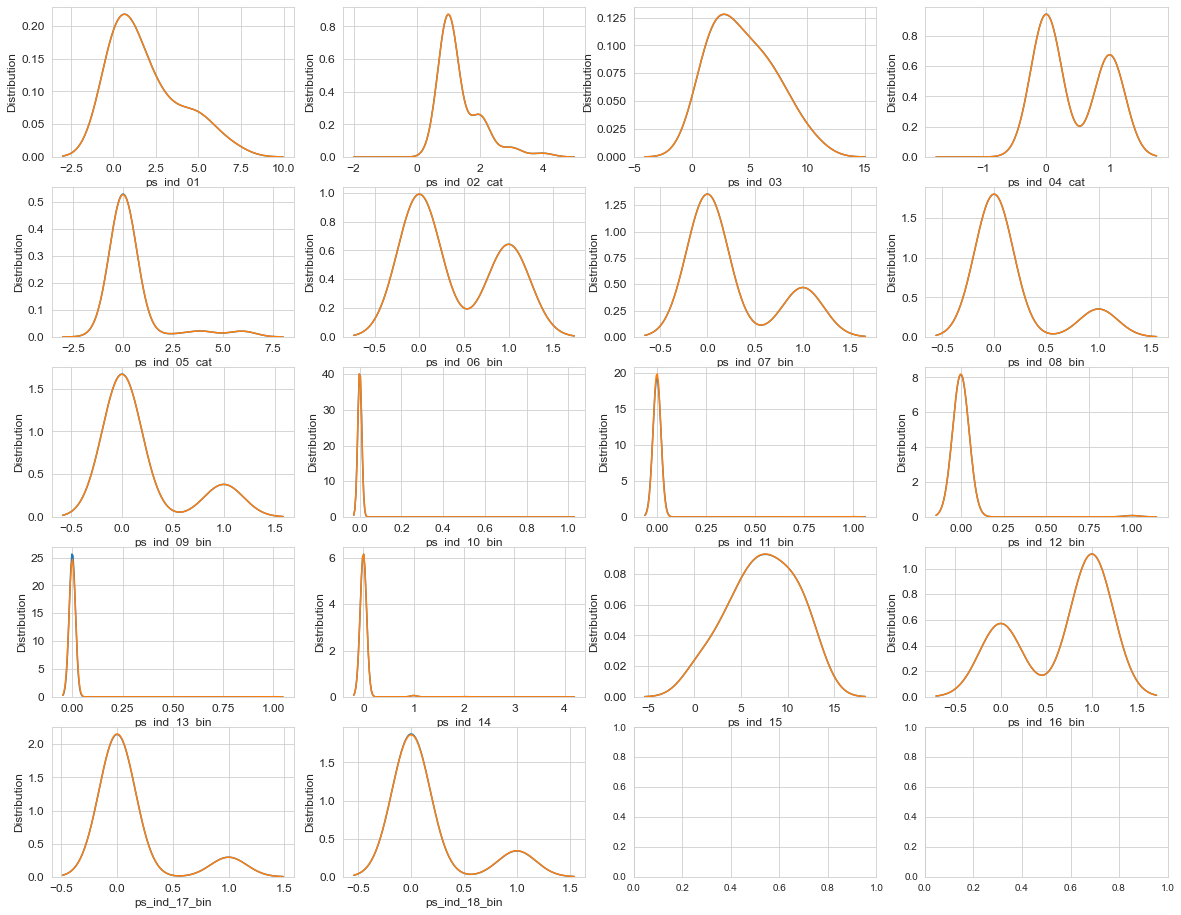

In [75]:
var = metadata[(metadata.category == 'individual') & (metadata.preserve)].index
sns.set_style('whitegrid')

fig, ax = plt.subplots(5, 4, figsize=(20, 16))
i = 0
for feature in var:
    i += 1
    plt.subplot(5, 4, i)
    sns.kdeplot(trainset[feature], bw=0.5, label="train")
    sns.kdeplot(testset[feature], bw=0.5, label="test")
    plt.ylabel('Distribution', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

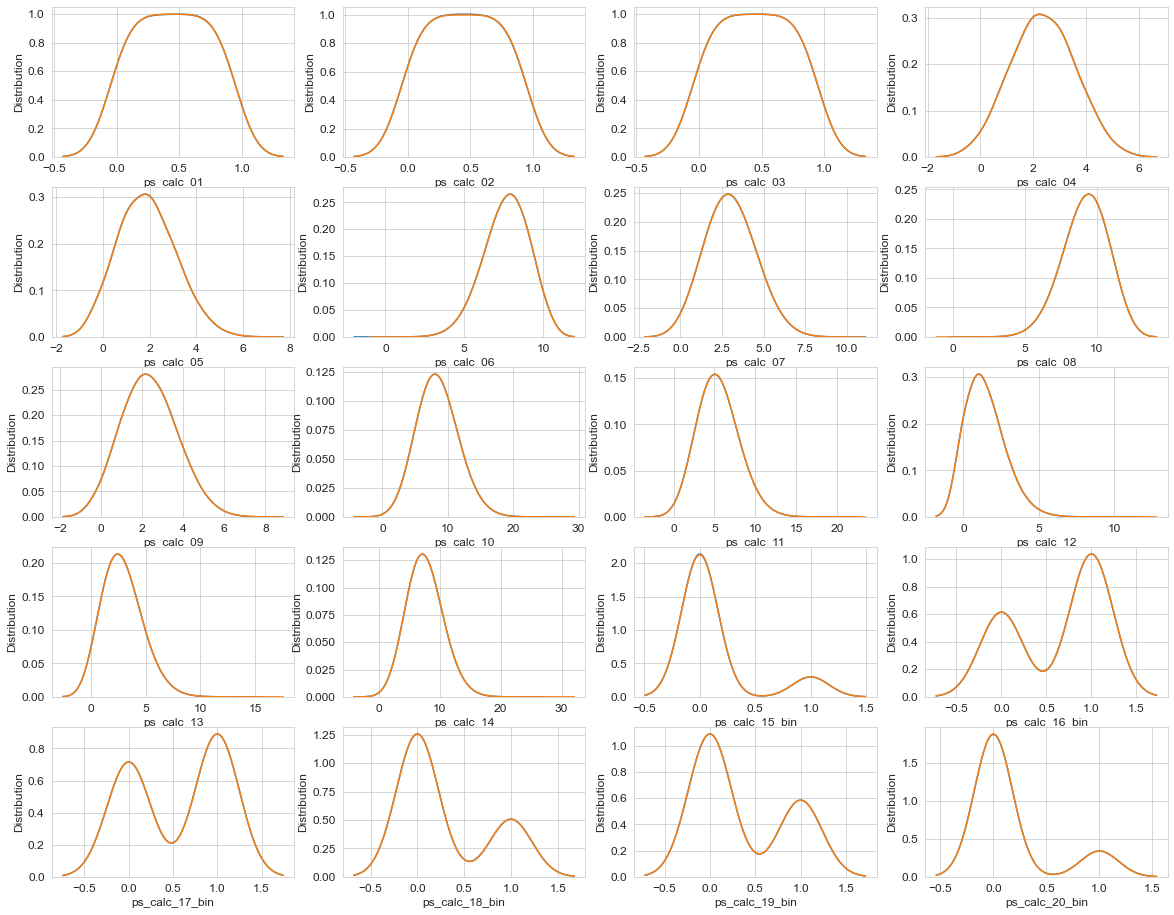

In [76]:
var = metadata[(metadata.category == 'calculated') & (metadata.preserve)].index
sns.set_style('whitegrid')

fig, ax = plt.subplots(5, 4, figsize=(20, 16))
i = 0
for feature in var:
    i += 1
    plt.subplot(5, 4, i)
    sns.kdeplot(trainset[feature], bw=0.5, label="train")
    sns.kdeplot(testset[feature], bw=0.5, label="test")
    plt.ylabel('Distribution', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

이상의 작업을 통해 훈련 데이터셋과 테스트 데이터셋에 대해 데이터가 고르게 분포되어 있음을 확인할 수 있었습니다.

## 데이터 품질 확인
각각의 변수들에 결측치가 포함되어 있는지 확인해 봅시다.

In [77]:
vars_with_missing = []

for feature in trainset.columns:
    missings = trainset[trainset[feature] == -1][feature].count() ## 결측치는 -1으로 코딩
    if missings > 0:
        vars_with_missing.append(feature)
        missings_perc = missings/trainset.shape[0]
        print('Variable {} has {} records ({:.2%}) with missing values'.format(feature, missings, missings_perc))

print('In total, there are {} variables with missing values'.format(len(vars_with_missing)))

Variable ps_ind_02_cat has 216 records (0.04%) with missing values
Variable ps_ind_04_cat has 83 records (0.01%) with missing values
Variable ps_ind_05_cat has 5809 records (0.98%) with missing values
Variable ps_reg_03 has 107772 records (18.11%) with missing values
Variable ps_car_01_cat has 107 records (0.02%) with missing values
Variable ps_car_02_cat has 5 records (0.00%) with missing values
Variable ps_car_03_cat has 411231 records (69.09%) with missing values
Variable ps_car_05_cat has 266551 records (44.78%) with missing values
Variable ps_car_07_cat has 11489 records (1.93%) with missing values
Variable ps_car_09_cat has 569 records (0.10%) with missing values
Variable ps_car_11 has 5 records (0.00%) with missing values
Variable ps_car_12 has 1 records (0.00%) with missing values
Variable ps_car_14 has 42620 records (7.16%) with missing values
In total, there are 13 variables with missing values


## 모델을 위해 데이터 준비하기
### `calc` 컬럼 삭제하기
이들을 삭제함으로써 CV score가 올라갔다고 하네요.

In [78]:
col_to_drop = trainset.columns[trainset.columns.str.startswith('ps_calc_')]
trainset = trainset.drop(col_to_drop, axis=1)
testset = testset.drop(col_to_drop, axis=1)

### 너무 많은 결측치가 있는 컬럼 삭제하기

In [79]:
vars_to_drop = ['ps_car_03_cat', 'ps_car_05_cat']
trainset.drop(vars_to_drop, inplace=True, axis=1)
testset.drop(vars_to_drop, inplace=True, axis=1)
metadata.loc[(vars_to_drop), 'keep'] = False

In [80]:
### `ps_car_11_cat`을 코딩된 값으로 변경하기

In [81]:
# Script by https://www.kaggle.com/ogrellier
# Code: https://www.kaggle.com/ogrellier/python-target-encoding-for-categorical-features
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None,
                  tst_series=None,
                  target=None,
                  min_samples_leaf=1,
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior
    """
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

위에서 정의한 함수를 사용하여 `ps_car_11`을 코딩된 값으로 변경합니다. (훈련 데이터셋과 테스트 데이터셋 모두에서)

In [82]:
train_encoded, test_encoded = target_encode(trainset["ps_car_11_cat"],
                                            testset["ps_car_11_cat"],
                                            target=trainset.target,
                                            min_samples_leaf=100,
                                            smoothing=10,
                                            noise_level=0.01)

trainset['ps_car_11_cat_te'] = train_encoded
trainset.drop('ps_car_11_cat', axis=1, inplace=True)

metadata.loc['ps_car_11_cat', 'keep'] = False

testset['ps_car_11_cat_te'] = test_encoded
testset.drop('ps_car_11_cat', axis=1, inplace=True)

### 타겟 변수의 균형 맞추기
타겟 변수는 극도로 불균형적입니다. 이는 `target=0`이 덜 샘플링 되었거나 `target=1`이 지나치게 많이 샘플링 되었다는 것을 의미합니다. 현재 가지고 있는 데이터셋의 크기가 크기 때문에, undersampling 을 하지 않기로 합니다.

In [83]:
desired_apriori = 0.10

idx_0 = trainset[trainset.target == 0].index
idx_1 = trainset[trainset.target == 1].index

nb_0 = len(trainset.loc[idx_0])
nb_1 = len(trainset.loc[idx_1])

undersampling_rate = ((1 - desired_apriori)*nb_1) / (nb_0*desired_apriori)
undersampled_nb_0 = int(undersampling_rate*nb_0)
print('Rate to undersample records with target=0: {}'.format(undersampling_rate))
print('Number of records with target=0 after undersampling: {}'.format(undersampled_nb_0))

undersampled_idx = shuffle(idx_0, random_state=314, n_samples=undersampled_nb_0)

idx_list = list(undersampled_idx) + list(idx_1)

trainset = trainset.loc[idx_list].reset_index(drop=True)

Rate to undersample records with target=0: 0.34043569687437886
Number of records with target=0 after undersampling: 195246


### `-1`을 `NaN`으로 대체하기

In [84]:
trainset = trainset.replace(-1, np.nan)
testset = testset.replace(-1, np.nan)

### 범주형 변수들에 대해 더미 변수들 만들기

In [85]:
cat_features = [a for a in trainset.columns if a.endswith('cat')]

for column in cat_features:
    temp = pd.get_dummies(pd.Series(trainset[column]))
    trainset = pd.concat([trainset, temp], axis=1)
    trainset = trainset.drop([column], axis=1)

for column in cat_features:
    temp = pd.get_dummies(pd.Series(testset[column]))
    testset = pd.concat([testset, temp], axis=1)
    testset = testset.drop([column], axis=1)

### 사용하지 않는 컬럼과 `target`컬럼 삭제하기
`id`와 `target` 컬럼을 따로 떼어내고, 훈련 세트와 테스트 세트에서는 해당 컬럼을 떼어냅니다.

In [86]:
id_test = testset['id'].values
target_train = trainset['target'].values

trainset = trainset.drop(['target', 'id'], axis=1)
testset = testset.drop(['id'], axis =1)

훈련 세트와 테스트 세트의 형태를 확인합니다.

In [87]:
print("Train dataset (rows, columns): ", trainset.values.shape, "\nTest dataset (rows, columns): ", testset.values.shape)

Train dataset (rows, columns):  (216940, 91) 
Test dataset (rows, columns):  (892816, 91)
